# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

I. Установите библиотеку CVXOPT, если она ещё не установлена, с помощью pip:

In [35]:
pip install cvxopt

II. Создайте Python-скрипт или Jupyter Notebook и импортируйте необходимые библиотеки:

In [36]:
import cvxopt
import cvxopt.solvers
import numpy as np

III. Задайте параметры задачи оптимизации, включая матрицу P, вектор q и матрицы G и h для ограничений. Ваша целевая функция и ограничения задаются следующим образом:

In [37]:
P = cvxopt.matrix([[2.0, 0.0], [0.0, 8.0]])
q = cvxopt.matrix([-8.0, -16.0])
G = cvxopt.matrix([[-1.0, -1.0, 0.0], [0.0, -1.0, -1.0]])
h = cvxopt.matrix([-5.0, 0.0, 0.0])


IV. Решите задачу оптимизации с помощью QP-солвера CVXOPT:

In [38]:
solution = cvxopt.solvers.qp(P, q, G, h)


     pcost       dcost       gap    pres   dres
 0: -2.8923e+01 -2.3107e+01  3e+01  1e+00  8e-01
 1: -2.9978e+01 -3.3726e+01  4e+00  5e-16  1e-16
 2: -3.0933e+01 -3.1028e+01  9e-02  0e+00  1e-16
 3: -3.0999e+01 -3.1000e+01  1e-03  5e-16  7e-17
 4: -3.1000e+01 -3.1000e+01  1e-05  2e-16  8e-17
Optimal solution found.


V. Извлеките результаты оптимизации, включая значения переменных и оптимальное значение функции:

In [40]:
optimal_x1 = solution['x'][0]
optimal_x2 = solution['x'][1]
optimal_value = solution['primal objective']


In [43]:
# Print the optimal solution and objective value
print("Optimal Solution:")
print(f"x1 = {optimal_x1}")
print(f"x2 = {optimal_x2}")
print(f"Optimal Value: {optimal_value}")

# Determine the active constraints
active_constraints = [i for i in range(len(solution['z'])) if solution['z'][i] != 0]

# Print active constraints
print("\nActive Constraints:")
for i in active_constraints:
    print(f"Constraint {i + 1}: {G[i] * solution['x'] - h[i]} <= 0")

# Determine and print inactive constraints
inactive_constraints = [i for i in range(len(solution['z'])) if i not in active_constraints]
print("\nInactive Constraints:")
for i in inactive_constraints:
    print(f"Constraint {i + 1}: {G[i] * solution['x'] - h[i]} > 0")


Optimal Solution:
x1 = 5.000003866589758
x2 = 2.000000142717409
Optimal Value: -30.999992266805457

Active Constraints:
Constraint 1: [-3.87e-06]
[ 3.00e+00]
 <= 0
Constraint 2: [-5.00e+00]
[-2.00e+00]
 <= 0
Constraint 3: [ 0.00e+00]
[ 0.00e+00]
 <= 0

Inactive Constraints:


## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

Набор данных 1: Линейно разделимые
Набор данных 2: Нелинейно разделимые
Набор данных 3: плохо разделимые


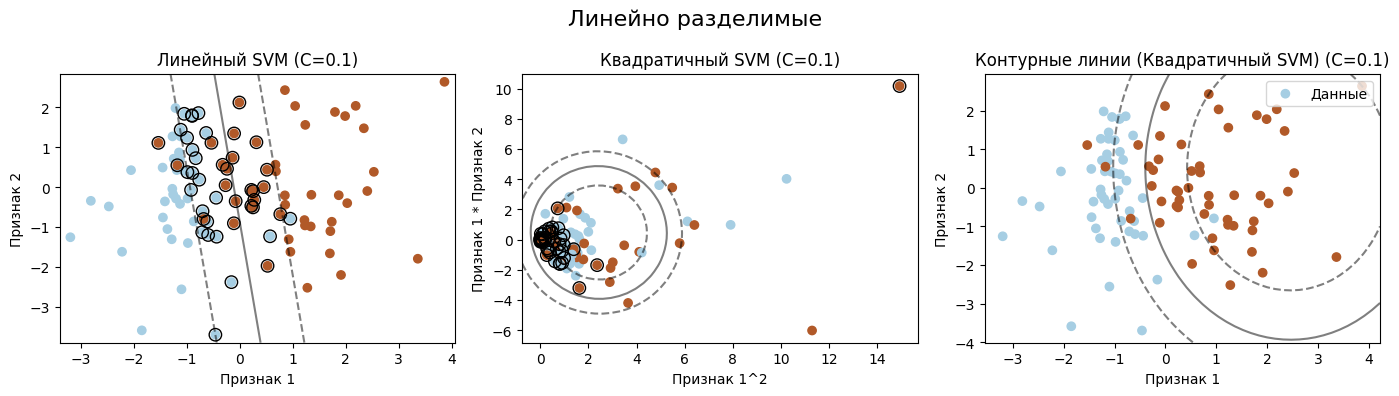

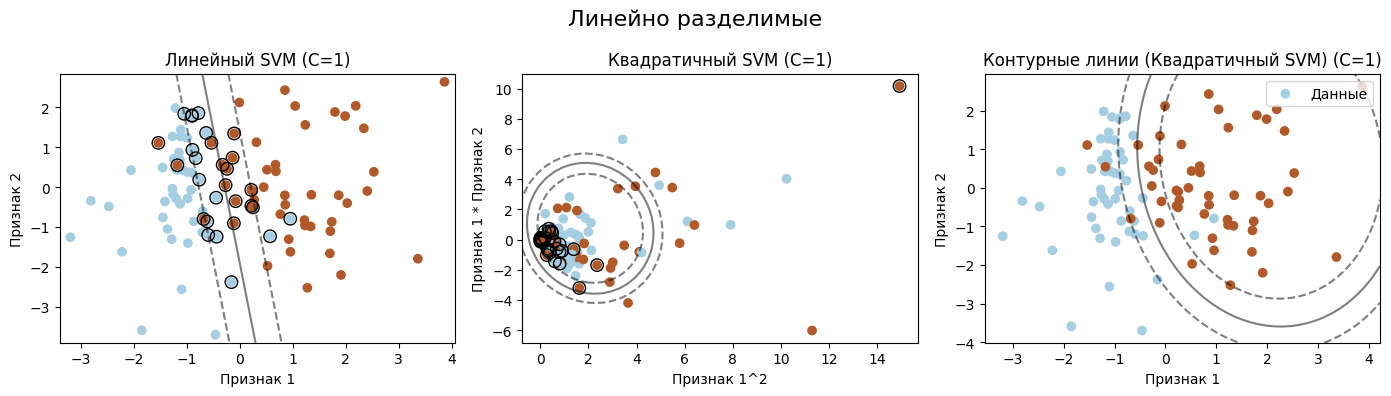

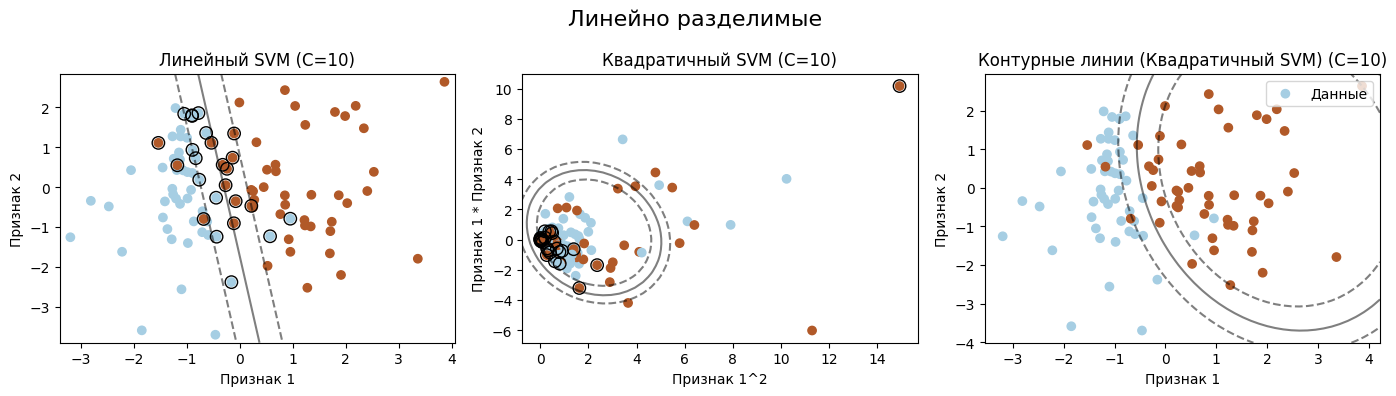

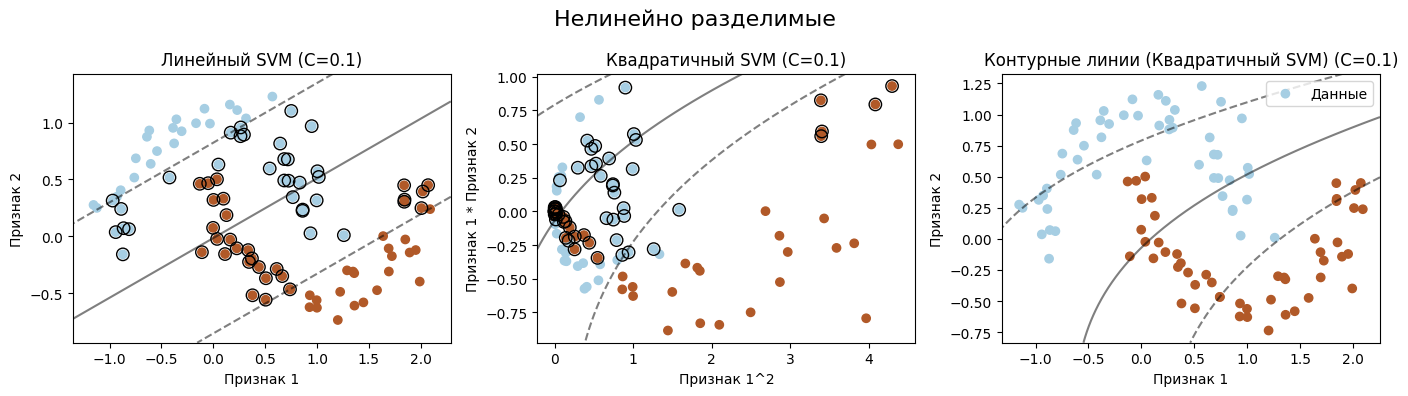

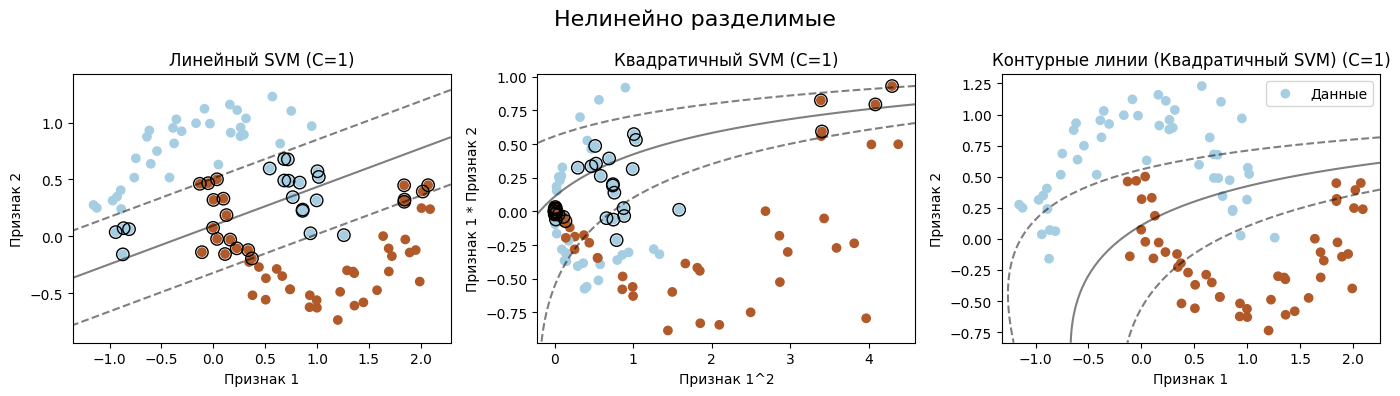

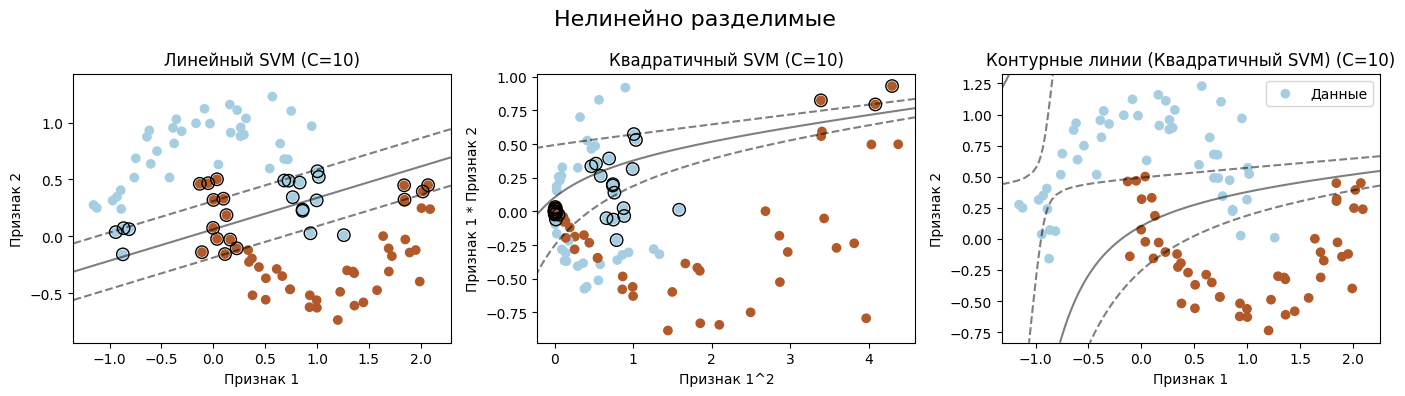

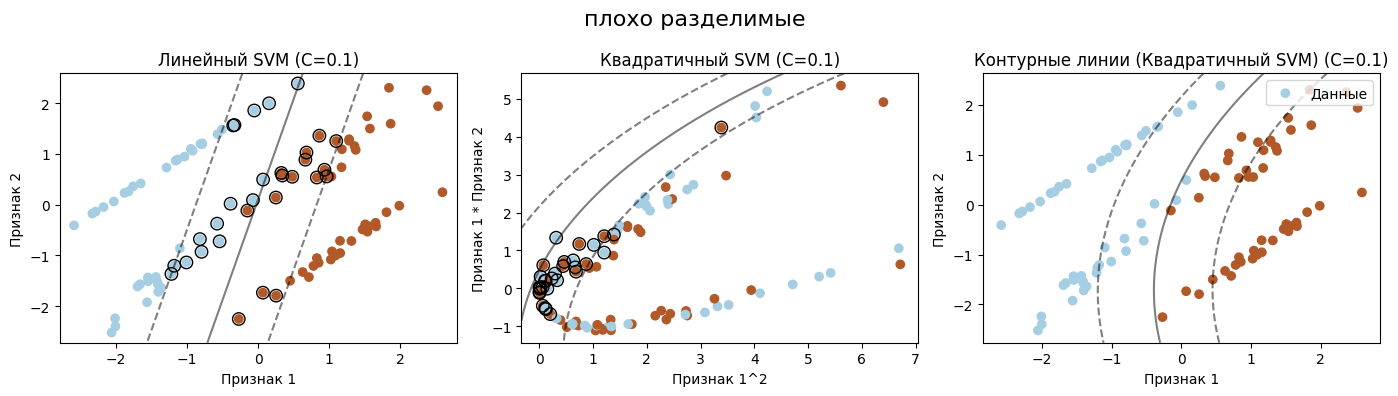

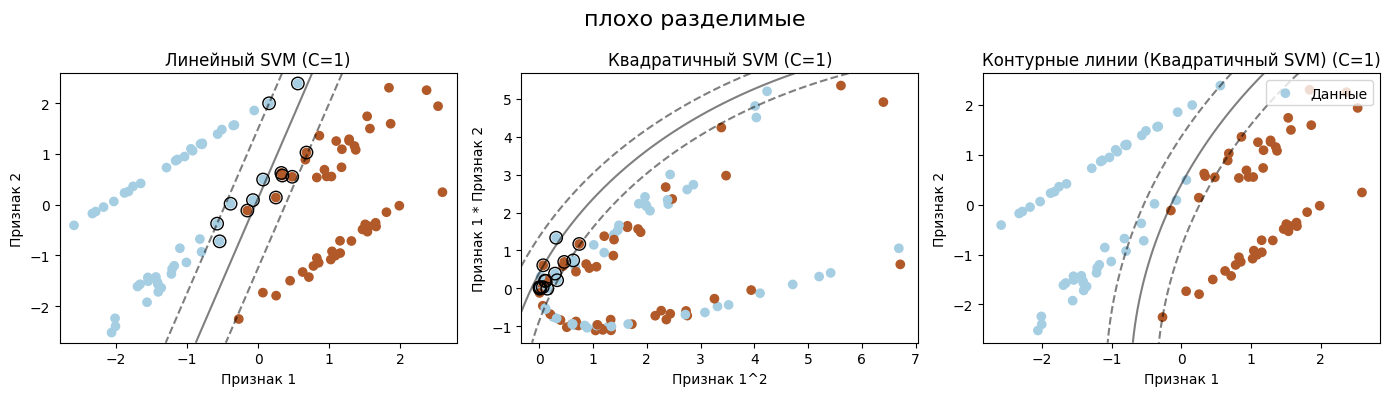

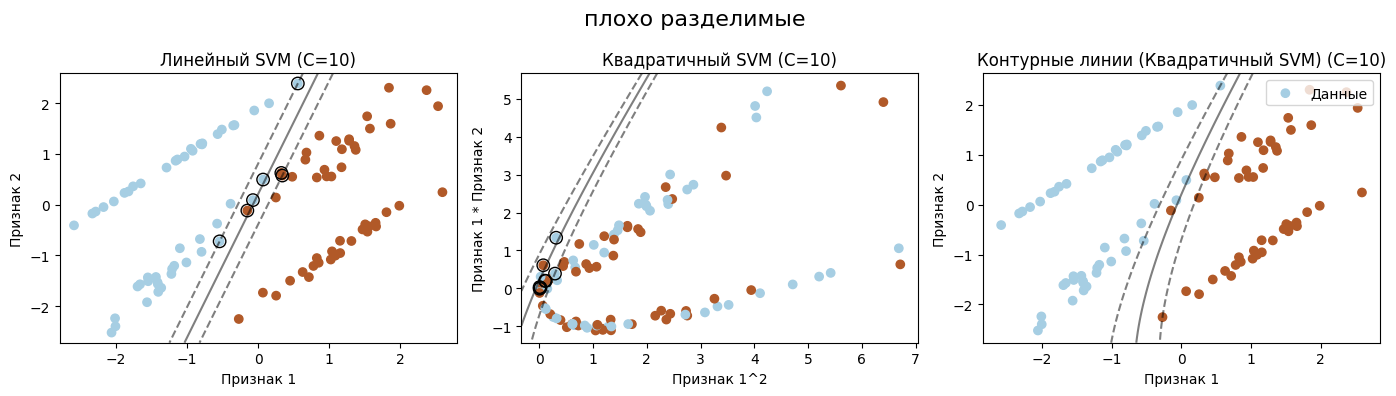

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Функция для создания синтетических наборов данных
def generate_datasets():
    # Линейно разделимый набор данных
    X_linear, y_linear = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=0)
    
    # Нелинейно разделимый набор данных
    X_nonlinear, y_nonlinear = datasets.make_moons(n_samples=100, noise=0.15, random_state=0)
    
    # Трудноразделимый набор данных
    X_hard, y_hard = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
    
    return (X_linear, y_linear), (X_nonlinear, y_nonlinear), (X_hard, y_hard)

# Функция для обучения и визуализации SVM
def train_and_visualize_svm(X, y, C, dataset_type):
    # Инициализация и обучение SVM с линейным ядром
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)
    
    plt.figure(figsize=(14, 4))
    
    # График данных и разделяющей прямой для линейного SVM
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, label='Данные')
    plt.xlim(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2)
    plt.ylim(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2)
    plt.title(f'Линейный SVM (C={C})')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # Отмечаем опорные векторы
    support_vectors = clf.support_vectors_
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=80, marker='o', edgecolors='k', facecolors='none', 
                label=f'Опорные векторы ({len(support_vectors)})')
    
    # Функция для явного преобразования признаков в квадратичное пространство
    def transform_features_quadratic(X):
        X_transformed = np.c_[X, X[:, 0]**2, X[:, 0] * X[:, 1], X[:, 1]**2]
        return X_transformed
    
    X_transformed = transform_features_quadratic(X)
    
    # Инициализация и обучение SVM с квадратичным ядром
    clf = SVC(kernel='linear', C=C)
    clf.fit(X_transformed, y)
    
    # График данных в квадратичном пространстве и разделяющей поверхности для SVM с квадратичным ядром
    plt.subplot(132)
    plt.scatter(X_transformed[:, 2], X_transformed[:, 3], c=y, cmap=plt.cm.Paired, label='Данные')
    plt.title(f'Квадратичный SVM (C={C})')
    plt.xlabel('Признак 1^2')
    plt.ylabel('Признак 1 * Признак 2')
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(transform_features_quadratic(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    # Отмечаем опорные векторы
    support_vectors = clf.support_vectors_
    plt.scatter(support_vectors[:, 2], support_vectors[:, 3], s=80, marker='o', edgecolors='k', facecolors='none', 
                label=f'Опорные векторы ({len(support_vectors)})')
    
    # График контурных линий разделяющей поверхности в квадратичном пространстве
    plt.subplot(133)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, label='Данные')
    plt.title(f'Контурные линии (Квадратичный SVM) (C={C})')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(transform_features_quadratic(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    plt.legend(loc='upper right')
    plt.suptitle(dataset_type, fontsize=16)
    
    plt.tight_layout()

# Генерируем наборы данных
datasets = generate_datasets()

# Значения гиперпараметра C для тестирования
C_values = [0.1, 1, 10]

# Перебираем наборы данных и значения C
for i, dataset in enumerate(datasets):
    X, y = dataset
    dataset_type = "Линейно разделимые" if i == 0 else "Нелинейно разделимые" if i == 1 else "плохо разделимые"
    print(f"Набор данных {i + 1}: {dataset_type}")
    for C in C_values:
        train_and_visualize_svm(X, y, C, dataset_type)

plt.show()

# Вывод
# В этом коде мы создаем синтетические наборы данных, обучаем и визуализируем метод опорных векторов (SVM)
# с различными значениями гиперпараметра C на линейных и квадратичных пространствах признаков.
# Результаты визуализируются с помощью графиков, показывая разделяющие прямые и контурные линии,
# а также опорные векторы. Это помогает исследовать, как различные значения C и признаковые
# преобразования влияют на обученные модели SVM в разных типах данных.


#### ВЫВОД:
На представленных графиках исследуется влияние параметра C на линейные и квадратичные методы опорных векторов (SVM) в трех различных типах наборов данных. Для линейно разделимых данных меньшие значения C приводят к широким разделяющим полосам и большему числу опорных векторов, тогда как большие значения C делают разделяющую полосу уже и уменьшают число опорных векторов. В случае нелинейно разделимых данных, используется квадратичный SVM после преобразования признаков, и наблюдается влияние параметра C на ширину разделяющей полосы и количество опорных векторов. Для сложных наборов данных, низкие значения C позволяют больше ошибок классификации и приводят к большему числу опорных векторов, в то время как высокие значения C уменьшают ошибки и опорные векторы. Графики иллюстрируют компромисс между шириной разделяющей полосы и ошибками классификации, зависящими от параметра C.

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [ ]:
%pylab inline

## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

In [ ]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [ ]:
np.array([True, False, False]) & np.array([True, False, True])

In [ ]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [ ]:
!pip install --upgrade --user cvxopt

Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [ ]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [ ]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

In [ ]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

In [ ]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

In [ ]:
sol

In [ ]:
print(sol['x'])

Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

In [ ]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [ ]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass